In [ ]:
# Carter Naegle & Cabot Steward

# READ ME

# We decided to put all the connection info into a .env inorder to put this on github more easily
# we used the dotenv library
 
# I added logging instead of the print statements we've used throughout class as they are much easier
# to navigate if you have an issue or want to CTRL + F to find information, we did this with the loggin
# package.  Plus they are faster

from dotenv import load_dotenv
import os
import psycopg2
import pymssql
import pandas as pd
from datetime import datetime
import csv
import logging
import numpy as np

environment = 'prod'

load_dotenv()
log_folder = 'logging'
os.makedirs(log_folder, exist_ok=True)

def get_connections():
    try:
        post_conn = psycopg2.connect(
            database=os.getenv('POSTGRES_DB'),
            user=os.getenv('POSTGRES_USER'),
            password=os.getenv('POSTGRES_PASSWORD'),
            host=os.getenv('POSTGRES_HOST'),
            port=os.getenv('POSTGRES_PORT')
        )
        post_cursor = post_conn.cursor()
        if environment == 'prod':
            schema = 'prod'
        else:
            schema = 'test'

        post_cursor.execute(f"SET search_path TO {schema};")


        ssms_conn = pymssql.connect(
            server=os.getenv('MSSQL_SERVER'),
            user=os.getenv('MSSQL_USER'),
            password=os.getenv('MSSQL_PASSWORD'),
            database=os.getenv('MSSQL_DB')
        )
        ssms_cursor = ssms_conn.cursor()

        return {
            'post_conn': post_conn,
            'post_cursor': post_cursor,
            'ssms_conn': ssms_conn,
            'ssms_cursor': ssms_cursor
        }
    except Exception as e:
        print(f"Error connecting to the database: {e}")
        return None

connections = get_connections()

if connections:
    post_conn = connections['post_conn']
    post_cursor = connections['post_cursor']
    ssms_conn = connections['ssms_conn']
    ssms_cursor = connections['ssms_cursor']

In [2]:
connections = get_connections()

if connections:
    post_conn = connections['post_conn']
    post_cursor = connections['post_cursor']
    ssms_conn = connections['ssms_conn']
    ssms_cursor = connections['ssms_cursor']

tables = [
  """CREATE TABLE IF NOT EXISTS weather_station (
    stadium_weather_station_id SERIAL PRIMARY KEY,
    stadium_weather_station_code VARCHAR(20),
    station_name VARCHAR(70),
    latitude NUMERIC(9,5),
    longitude NUMERIC(9,5),
    elevation NUMERIC(7,2)
  );""",
  """CREATE TABLE IF NOT EXISTS nfl_stadium (
    stadium_id SERIAL PRIMARY KEY,
    stadium_name VARCHAR(50) NOT NULL,
    stadium_city VARCHAR(50),
    stadium_state VARCHAR(20),
    stadium_open_year DATE,
    stadium_close_year DATE,
    stadium_type VARCHAR(15),
    stadium_surface VARCHAR(50),
    stadium_capacity INT,
    stadium_weather_type VARCHAR(10),
    stadium_weather_station_id INT,
    CONSTRAINT FK_nfl_stadium_weather_station_id
      FOREIGN KEY (stadium_weather_station_id)
      REFERENCES weather_station(stadium_weather_station_id)
  );""",
  """CREATE TABLE IF NOT EXISTS customer (
    customer_id SERIAL PRIMARY KEY,
    customer_first_name VARCHAR(50) NOT NULL,
    customer_last_name VARCHAR(50) NOT NULL,
    customer_age SMALLINT NOT NULL,
    customer_type VARCHAR(25) NOT NULL,
    customer_since DATE NOT NULL,
    customer_income INT,
    household_size SMALLINT,
    mode_color VARCHAR(10),
    source_customer_id INT
  );""",
  """CREATE TABLE IF NOT EXISTS teams (
    team_id SERIAL PRIMARY KEY,
    team_name VARCHAR(50) NOT NULL,
    team_name_short VARCHAR(25) NOT NULL,
    team_abv VARCHAR(4) NOT NULL,
    team_abv_pfr VARCHAR(4) NOT NULL,
    team_conference VARCHAR(4) NOT NULL,
    team_division VARCHAR(12),
    team_conference_pre2002 VARCHAR(4) NOT NULL,
    team_division_pre2002 VARCHAR(15)
  );""",
    """CREATE TABLE IF NOT EXISTS game (
      game_outcome_id SERIAL PRIMARY KEY,
      schedule_date DATE NOT NULL,
      schedule_season INT NOT NULL,
      schedule_week VARCHAR(12) NOT NULL,
      schedule_playoff BOOLEAN NOT NULL,
      team_id_home INT NOT NULL,
      score_home SMALLINT NOT NULL,
      team_id_away INT NOT NULL,
      score_away SMALLINT NOT NULL,
      winner_ou VARCHAR(6) NOT NULL,
      winner_line VARCHAR(8) NOT NULL,
      team_favored INT,
      favored_spread NUMERIC(3,1) NOT NULL,
      over_under_line NUMERIC(3,1) NOT NULL,
      stadium_id INT NOT NULL,
      stadium_neutral BOOLEAN NOT NULL,
      weather_temperature SMALLINT,
      weather_wind_mph SMALLINT,
      weather_humidity SMALLINT,
      weather_detail VARCHAR(40),
      CONSTRAINT FK_game_stadium_id
        FOREIGN KEY (stadium_id)
        REFERENCES nfl_stadium(stadium_id),
      CONSTRAINT FK_game_team_id_home
        FOREIGN KEY (team_id_home)
        REFERENCES teams(team_id),
      CONSTRAINT FK_game_team_id_away
        FOREIGN KEY (team_id_away)
        REFERENCES teams(team_id),
        CONSTRAINT FK_game_team_favored
        FOREIGN KEY (team_favored)
        REFERENCES teams(team_id)
    );""",
  """CREATE TABLE IF NOT EXISTS placed_bet (
    bet_id SERIAL PRIMARY KEY,
    customer_id INT NOT NULL,
    game_outcome_id INT NOT NULL,
    bet_amount SMALLINT NOT NULL,
    bet_result VARCHAR(4),
    commision_paid NUMERIC(8,2) NOT NULL,
    bet_on VARCHAR(40),
    bet_type VARCHAR(10),
    CONSTRAINT FK_placed_bet_customer_id
      FOREIGN KEY (customer_id)
      REFERENCES customer(customer_id),
    CONSTRAINT FK_placed_bet_game_outcome_id
      FOREIGN KEY (game_outcome_id)
      REFERENCES game(game_outcome_id)
  );"""
]

for i in tables:
  post_cursor.execute(i)

post_conn.commit()

In [3]:
# Populate Customer Table
connections = get_connections()

if connections:
    post_conn = connections['post_conn']
    post_cursor = connections['post_cursor']
    ssms_conn = connections['ssms_conn']
    ssms_cursor = connections['ssms_cursor']

log_file = os.path.join(log_folder, f"customer_upload_{datetime.now().strftime('%Y%m%d')}.log")
logging.basicConfig(
    filename=log_file,
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    filemode='w'  
)
    
query = """SELECT * FROM customer_table """

try:
    df = pd.read_sql(query, ssms_conn)
    df[['customer_first_name', 'customer_last_name']] = df['customer_name'].str.split(n=1, expand=True)
    df['customer_since'] = df['customer_since'].apply(lambda x: datetime(int(x), 1, 1).strftime('%Y-%m-%d'))

    df.drop('customer_name', axis=1, inplace=True)
    df.rename(columns={'customer_id': 'source_customer_id'}, inplace=True)

    db_column_order = [
        'customer_first_name',
        'customer_last_name',
        'customer_age',
        'customer_type',
        'customer_since',
        'customer_income',
        'household_size',
        'mode_color',
        'source_customer_id'
    ]
    
    df = df[db_column_order]

    temp_csv = 'customer_temp.csv'
    df.to_csv(temp_csv, index=False)

    with open(temp_csv, 'r') as file:
        post_cursor.copy_expert(
            """
            COPY customer (
                customer_first_name,
                customer_last_name,
                customer_age,
                customer_type,
                customer_since,
                customer_income,
                household_size,
                mode_color,
                source_customer_id
            )
            FROM STDIN WITH CSV HEADER
            """,
            file
        )
    post_conn.commit()
    logging.info("All customer data has been successfully inserted.")
    print("All Data Ingested Successfully!")

except Exception as e:
    logging.error(f"Error occurred during customer data ingestion: {e}")
    post_conn.rollback()

finally:
    if 'temp_csv' in locals() and os.path.exists(temp_csv):
        os.remove(temp_csv)
        logging.info(f"Temporary file '{temp_csv}' has been deleted.")

C:\Users\tucke\AppData\Local\Temp\ipykernel_29712\241823558.py:21: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, ssms_conn)


All Data Ingested Successfully!


In [4]:
# Inserting Teams
connections = get_connections()

if connections:
    post_conn = connections['post_conn']
    post_cursor = connections['post_cursor']
    ssms_conn = connections['ssms_conn']
    ssms_cursor = connections['ssms_cursor']

for handler in logging.root.handlers[:]:
    logging.root.removeHandler(handler)

log_file = os.path.join(log_folder, f"teams_{datetime.now().strftime('%Y%m%d')}.log")
logging.basicConfig(
    filename=log_file,
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    filemode='w' 
)

csv_teams = 'nfl_teams.csv'
teams_df = pd.read_csv(csv_teams)

teams_df['team_id'] = teams_df['team_id'].replace({'LVR': 'LV'})

temp_csv = 'teams_temp.csv'
teams_df.to_csv(temp_csv, index=False)

try:
    with open(temp_csv, 'r') as file:
        post_cursor.copy_expert(
            """
            COPY teams (
                team_name,
                team_name_short,
                team_abv,
                team_abv_pfr,
                team_conference,
                team_division,
                team_conference_pre2002,
                team_division_pre2002
            )
            FROM STDIN WITH CSV HEADER
            """,
            file
        )
    post_conn.commit()
    logging.info("All team data has been successfully inserted.")
except Exception as e:
    logging.error(f"Error occurred during insertion: {e}")
    post_conn.rollback()
finally:
    if os.path.exists(temp_csv):
        os.remove(temp_csv)
        logging.info(f"Temporary file '{temp_csv}' has been deleted.")


In [5]:
# weather stations
connections = get_connections()

if connections:
    post_conn = connections['post_conn']
    post_cursor = connections['post_cursor']
    ssms_conn = connections['ssms_conn']
    ssms_cursor = connections['ssms_cursor']

for handler in logging.root.handlers[:]:
    logging.root.removeHandler(handler)

log_file = os.path.join(log_folder, f"weather_stations_{datetime.now().strftime('%Y%m%d')}.log")
logging.basicConfig(
    filename=log_file,
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    filemode='w'  
)

csv_stadiums = 'nfl_stadiums.csv'
temp_csv_file = 'temp_weather_station_upload.csv'

weather_df = pd.read_csv(csv_stadiums, encoding='latin1')
weather_df = weather_df.dropna(subset=['STATION']).drop_duplicates(subset=['STATION'])

bulk_data = []
error_rows = []

for index, row in weather_df.iterrows():
    try:
        post_cursor.execute(
            'SELECT count(*) FROM weather_station WHERE stadium_weather_station_code = %s;', 
            (row['STATION'],)
        )
        result = post_cursor.fetchone()

        if result[0] != 0:
            logging.error(f"Weather station {row['STATION']} already exists, skipping.")
            continue

        bulk_data.append([
            row['STATION'],  
            row['NAME'],    
            float(row['LATITUDE']),  
            float(row['LONGITUDE']),  
            float(row['ELEVATION'])  
        ])

    except Exception as e:
        logging.error(f"Error processing row {index}: {e} {row.to_dict()}")
        error_rows.append(row.to_dict())

with open(temp_csv_file, 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['stadium_weather_station_code', 'station_name', 'latitude', 'longitude', 'elevation'])
    writer.writerows(bulk_data)

try:
    with open(temp_csv_file, 'r') as file:
        post_cursor.copy_expert(
            """COPY weather_station (
                stadium_weather_station_code, station_name, latitude, longitude, elevation
            ) FROM STDIN WITH CSV HEADER""",
            file
        )
    post_conn.commit()
    logging.info(f"Successfully inserted bulk data from {temp_csv_file}")
except Exception as e:
    post_conn.rollback()
    logging.error(f"Error during bulk insert: {e}")
finally:
    if os.path.exists(temp_csv_file):
        os.remove(temp_csv_file)
        logging.info(f"Temporary file '{temp_csv_file}' deleted.")


In [6]:
# stadium
connections = get_connections()

if connections:
    post_conn = connections['post_conn']
    post_cursor = connections['post_cursor']
    ssms_conn = connections['ssms_conn']
    ssms_cursor = connections['ssms_cursor']

for handler in logging.root.handlers[:]:
    logging.root.removeHandler(handler)

log_file = os.path.join(log_folder, f"stadium_{datetime.now().strftime('%Y%m%d')}.log")
logging.basicConfig(
    filename=log_file,
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    filemode='w' 
)

csv_stadiums = 'nfl_stadiums.csv'
bulk_data = []
error_rows = []

stadium_df = pd.read_csv(csv_stadiums, encoding='latin1')
stadium_df[['city', 'state']] = stadium_df['stadium_location'].str.split(', ', expand=True)


for index, row in stadium_df.iterrows():   
    try:
        post_cursor.execute(
                'select count(*) from nfl_stadium where stadium_name = %s;', 
                (row['stadium_name'],)
            )
        result = post_cursor.fetchone()

        if result[0] != 0:
            logging.error(f"This record already exists: {row.to_dict()}")
            continue
        
        stadium_open = None
        if pd.notna(row['stadium_open']):
            stadium_open = datetime.date(int(row['stadium_open']), 1, 1)

        stadium_close = None
        if pd.notna(row['stadium_close']):
            stadium_close = datetime.date(int(row['stadium_close']), 1, 1)

        stadium_capacity = None
        if pd.notna(row['stadium_capacity']):
            stadium_capacity = int(row['stadium_capacity'].replace(',', ''))


        stadium_weather_station_id = None
        if pd.notna(row['STATION']):
            post_cursor.execute(
                'SELECT stadium_weather_station_id FROM weather_station WHERE stadium_weather_station_code = %s;', 
                (row['STATION'],)
            )
            weather_result = post_cursor.fetchone()
            if weather_result:
                stadium_weather_station_id = weather_result[0]

        stadium_surface = None
        if pd.notna(row['stadium_surface']):
            stadium_surface = row['stadium_surface'].split(',')[0].strip()

        stadium_weather_type = None
        if pd.notna(row['stadium_weather_type']):
            stadium_weather_type = row['stadium_capacity']

        stadium_type = None
        if pd.notna(row['stadium_type']):
            stadium_type = row['stadium_type']

        bulk_data.append([
                stadium_weather_station_id,
                row['stadium_name'],
                row['city'],
                row['state'],
                stadium_open,
                stadium_close,
                stadium_type,
                stadium_surface,
                stadium_capacity,
                stadium_weather_type
            ])
        logging.info(f"Stadium {row['stadium_name']} is ready to be written to csv")

    except Exception as e:
        logging.error(f"Error processing row {index}: {e} {row.to_dict()}")
        error_rows.append(row.to_dict())

temp_csv_file = 'temp_nfl_stadium_upload.csv'

with open(temp_csv_file, 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow([
        'stadium_weather_station_id', 'stadium_name', 'stadium_city', 
        'stadium_state', 'stadium_open_year', 'stadium_close_year', 
        'stadium_type', 'stadium_surface', 'stadium_capacity', 'stadium_weather_type'
    ])
    writer.writerows(bulk_data)
    logging.info(f"Successfully wrote all data to csv: {temp_csv_file}")


try:
    with open(temp_csv_file, 'r') as file:
        post_cursor.copy_expert(
            """COPY nfl_stadium (
                stadium_weather_station_id, stadium_name, stadium_city, 
                stadium_state, stadium_open_year, stadium_close_year, 
                stadium_type, stadium_surface, stadium_capacity, stadium_weather_type
            ) FROM STDIN WITH CSV HEADER""",
            file
        )
    post_conn.commit()
    logging.info(f"Successfully inserted bulk data from {temp_csv_file}")
    os.remove(temp_csv_file)
except Exception as e:
    post_conn.rollback()
    logging.error(f"Error during bulk insert: {e}")
finally:
    pass
    


In [7]:
# game

connections = get_connections()

if connections:
    post_conn = connections['post_conn']
    post_cursor = connections['post_cursor']
    ssms_conn = connections['ssms_conn']
    ssms_cursor = connections['ssms_cursor']

for handler in logging.root.handlers[:]:
    logging.root.removeHandler(handler)

log_file = os.path.join(log_folder, f"game_{datetime.now().strftime('%Y%m%d')}.log")
logging.basicConfig(
    filename=log_file,
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    filemode='w' 
)

csv_file = 'spread_scores-2.csv'
game = pd.read_csv(csv_file)
game = game[game['schedule_season'] >= 2015]

error_csv = 'failed_inserts.csv'
error_rows = []

nullable = ['weather_temperature', 'weather_wind_mph', 'weather_humidity', 'weather_detail', 'team_favorite_id']
game[nullable] = game[nullable].replace({np.nan: None})

game['schedule_date'] = pd.to_datetime(game['schedule_date'], format='%m/%d/%Y', errors='coerce')

def get_team_id(values):
    post_cursor.execute(
        'SELECT team_id FROM teams WHERE team_name = %s;',
        (values,)
    )
    team_id = post_cursor.fetchone()
    return team_id[0] if team_id else None

def get_team_favorite_id(values):
    if values == 'PICK':
        return None
    post_cursor.execute(
        'SELECT team_id FROM teams WHERE team_abv = %s;',
        (values,)
    )
    team_favorite_id = post_cursor.fetchone()
    return team_favorite_id[0] if team_favorite_id else None

def get_stadium_id(values):
    post_cursor.execute(
        'SELECT stadium_id FROM nfl_stadium WHERE stadium_name = %s;',
        (values,)
    )
    stadium_id = post_cursor.fetchone()

    if stadium_id == None:
        insert_stadium = (
            """insert into nfl_stadium (stadium_name) values (%s) returning stadium_id"""
        )
        post_cursor.execute(insert_stadium, (values,))
        stadium_id = post_cursor.fetchone()

    return stadium_id[0]

def calculate_betting_results(row):
    total_points = row['score_home'] + row['score_away']
    if total_points > row['over_under_line']:
        winner_ou = 'over'
    elif total_points < row['over_under_line']:
        winner_ou = 'under'
    else:
        winner_ou = 'push'

    # Spread
    margin = (
        row['score_home'] - row['score_away']
        if row['team_favorite_id'] == row['team_home']
        else row['score_away'] - row['score_home']
    )
    if margin > row['spread_favorite']:
        winner_line = 'favored'
    elif margin < row['spread_favorite']:
        winner_line = 'underdog'
    else:
        winner_line = 'push'

    return winner_ou, winner_line

def parse_int(values, allow_negative=False):
# allow_negative: True, allow negative integers; if False, return None for negatives.
    try:
        result = int(values)
        if not allow_negative and result < 0:
            return None
        return result
    except:
        return None

for index, row in game.iterrows():
    query = """select count(*) 
                from game 
                where team_id_home in (
                		select team_id
                		from teams 
                		where team_name = %s)
                	and schedule_date = %s"""
    post_cursor.execute(query, (row['team_home'], row['schedule_date']))
    duplicate_game = post_cursor.fetchone()

    if duplicate_game[0] > 0:
        logging.warning(f"game already exists for {row['team_home']} {row['schedule_date']}.")
        continue
    
    try:
        team_id_home = get_team_id(row['team_home'])
        team_id_away = get_team_id(row['team_away'])
        stadium_id = get_stadium_id(row['stadium'])
        team_id_favorite = get_team_favorite_id(row['team_favorite_id'])
        weather_temperature = parse_int(row['weather_temperature'], allow_negative=True)
        weather_wind = parse_int(row['weather_wind_mph'])
        weather_humidity = parse_int(row['weather_humidity'])

        weather_detail = None
        if pd.notna(row['weather_detail']):
            weather_detail = row['weather_detail']

        winner_ou, winner_line = calculate_betting_results(row)


        game_insert_query = """INSERT INTO game (schedule_date,
                                                schedule_season,
                                                schedule_week,
                                                schedule_playoff,
                                                team_id_home,
                                                score_home,
                                                team_id_away,
                                                score_away,
                                                winner_ou,
                                                winner_line,
                                                team_favored,
                                                favored_spread,
                                                over_under_line,
                                                stadium_id,
                                                stadium_neutral,
                                                weather_temperature,
                                                weather_wind_mph,
                                                weather_humidity,
                                                weather_detail)
                                  VALUES (%s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s)"""

        post_cursor.execute(game_insert_query, (
            row['schedule_date'],
            row['schedule_season'],
            row['schedule_week'],
            row['schedule_playoff'],
            team_id_home,
            row['score_home'],
            team_id_away,
            row['score_away'],
            winner_ou,
            winner_line,
            team_id_favorite,
            row['spread_favorite'],
            row['over_under_line'],
            stadium_id,
            row['stadium_neutral'],
            weather_temperature,
            weather_wind,
            weather_humidity,
            weather_detail
        ))

        post_conn.commit()

        logging.info(f"Successfully uploaded record: {row.to_dict()}")

    except Exception as e:
        logging.error(f"Error processing row {index}: {e} {row.to_dict()}")
        error_rows.append(row.to_dict())
        post_conn.rollback()

post_conn.commit()


if error_rows:
    with open(error_csv, 'w', newline='', encoding='utf-8') as csvfile:
        fieldnames = game.columns
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        writer.writeheader()
        writer.writerows(error_rows)

logging.info("Game upload complete.")

if error_rows:
    logging.warning(f"Some rows failed. Check {error_csv} for details.")
    print('Some rows failed, check logging')
else:
    print('All rows imported with no failures.')

All rows imported with no failures.


In [5]:
# placed bet
connections = get_connections()

if connections:
    post_conn = connections['post_conn']
    post_cursor = connections['post_cursor']
    ssms_conn = connections['ssms_conn']
    ssms_cursor = connections['ssms_cursor']
    
for handler in logging.root.handlers[:]:
    logging.root.removeHandler(handler)

log_file = os.path.join(log_folder, f"placed_bet_{datetime.now().strftime('%Y%m%d')}.log")
logging.basicConfig(
    filename=log_file,
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    filemode='w' 
)
# removed TEMP from it for now
temp_table = """CREATE TEMP TABLE IF NOT EXISTS placed_bet_staging (
        bet_amount SMALLINT NOT NULL,
        commission_paid NUMERIC(8,2),
        bet_on VARCHAR(40),
        bet_type VARCHAR(10),
        customer_name VARCHAR(50),
        game_id VARCHAR(30),
        source_customer_id INT,
        ingested BOOLEAN DEFAULT FALSE
);"""

post_cursor.execute(temp_table)

post_conn.commit()

query = """
with cte as (
SELECT 
    bet_amount,  
    CASE
        WHEN bet_amount <= 1000 THEN bet_amount * 0.1
        WHEN bet_amount <= 4000 THEN (1000 * 0.1) + ((bet_amount - 1000) * 0.08)
        ELSE (1000 * 0.1) + (3000 * 0.08) + ((bet_amount - 4000) * 0.06)
    END AS commission_paid,
    bet_on,
    CASE 
        WHEN bet_on IN ('under', 'over', 'push') THEN LOWER(bet_on)
        ELSE 'line' 
    END AS bet_type,
    ct.customer_name,
    game_id, 
    ct.customer_id
FROM betlog bl
INNER JOIN customer_table ct ON bl.customer_id = ct.customer_id
where bet_amount is not NULL 
	and bet_on is not NULL)
select * 
from cte 
where commission_paid is not NULL
	and customer_name is not NULL 
	and game_id is not NULL
	and customer_id is not NULL
;
"""

try:
    df = pd.read_sql(query, ssms_conn)
    df = df.dropna(how='all')

    csv_file = 'placed_bet_staging.csv'
    df.to_csv(csv_file, index=False)

    with open(csv_file, 'r') as file:
        next(file) 
        post_cursor.copy_expert(
            f"""
            COPY placed_bet_staging (
                bet_amount, commission_paid, bet_on, bet_type, customer_name, game_id, source_customer_id
            )
            FROM STDIN WITH CSV
            DELIMITER ','
            """,
            file
        )
        post_conn.commit()

    print("Ingestion Successfull")
    logging.info("Data successfully copied to PostgreSQL staging table.")
    os.remove(csv_file)
    logging.info(f"Temporary file '{csv_file}' deleted.")


except Exception as e:
    print(f"Error during data processing: {e}")
    logging.error(f"Error during data processing: {e}")

finally:
    pass

stage_to_prod = """
WITH 
TeamOccurrences AS (
    SELECT 
        t.team_id,
        t.team_name,
        t.team_abv,
        COUNT(*) AS occurrences,
        ROW_NUMBER() OVER (PARTITION BY t.team_name ORDER BY COUNT(*) DESC) AS row_num
    FROM 
        teams t
    INNER JOIN 
        game g 
        ON t.team_id = g.team_id_home
    WHERE 
        g.schedule_date >= NOW() - INTERVAL '1 year'
    GROUP BY 
        t.team_id, t.team_name),
game_data AS (
    SELECT 
        pbs.bet_amount,
        pbs.commission_paid,
        pbs.bet_on,
        pbs.bet_type,
        pbs.customer_name,
        pbs.game_id,
        pbs.source_customer_id,
        th.team_id AS home_team_id,
        th.team_abv AS home_team_abv,
        ta.team_id AS away_team_id,
        ta.team_abv AS away_team_abv,
        g.game_outcome_id,
        g.winner_line,
        g.schedule_date,
        g.score_home,
        g.score_away,
        c.customer_id,
        g.favored_spread
     FROM placed_bet_staging pbs
    FULL OUTER JOIN TeamOccurrences th
        ON th.team_abv = case when split_part(pbs.game_id, '-', 2) in ('JAC') then 'JAX' else split_part(pbs.game_id, '-', 2) end -- Home team abbreviation
        and th.row_num = 1
    FULL OUTER JOIN TeamOccurrences ta
        ON ta.team_abv = case when split_part(pbs.game_id, '-', 3) in ('JAC') then 'JAX' else split_part(pbs.game_id, '-', 3) end  -- Away team abbreviation
        and th.row_num = 1
--        and team
    full OUTER JOIN game g
        ON g.schedule_season = LEFT(pbs.game_id, 4)::INT -- Extract year
        AND CASE
        	WHEN schedule_week = 'Wildcard' THEN 19
        	WHEN schedule_week = 'Division' THEN 20
        	WHEN schedule_week = 'Conference' THEN 21
        	WHEN schedule_week = 'Superbowl' THEN 22
        	ELSE schedule_week::INT end = right(split_part(pbs.game_id, '-', 1),2)::INT -- Extract week
        AND g.team_id_home = th.team_id
        AND g.team_id_away = ta.team_id
    INNER JOIN customer c
        ON c.customer_id = pbs.source_customer_id
     where LEFT(split_part(pbs.game_id, '-', 1), 4)::INT > 2015
),
bet_outcomes AS (
    SELECT 
        gd.customer_id,
        gd.game_outcome_id,
        gd.bet_amount,
        CASE 
            WHEN gd.bet_type = 'line' AND gd.bet_on = gd.winner_line THEN 'win'
            WHEN gd.bet_type = 'line' AND gd.bet_on != gd.winner_line THEN 'lose'
            WHEN gd.bet_type = 'over' AND (gd.score_home + gd.score_away) > gd.favored_spread THEN 'win'
            WHEN gd.bet_type = 'over' AND (gd.score_home + gd.score_away) <= gd.favored_spread THEN 'lose'
            WHEN gd.bet_type = 'under' AND (gd.score_home + gd.score_away) < gd.favored_spread THEN 'win'
            WHEN gd.bet_type = 'under' AND (gd.score_home + gd.score_away) >= gd.favored_spread THEN 'lose'
            ELSE 'push'
        END AS bet_result,
        gd.commission_paid,
        gd.bet_on,
        gd.bet_type
    FROM game_data gd
)
INSERT INTO placed_bet (
    customer_id,
    game_outcome_id,
    bet_amount,
    bet_result,
    commision_paid,
    bet_on,
    bet_type)
    SELECT 
    customer_id,
    game_outcome_id,
    bet_amount,
    bet_result,
    commission_paid as commision_paid,
    bet_on,
    bet_type
FROM bet_outcomes;
"""

try:
    post_cursor.execute(stage_to_prod)
    post_conn.commit()

    print("successfully moved out of staging")
    logging.info('Inserting into prod successfully')
except Exception as e:
    print(f"Error executing query: {e}")
    logging.error(f"Error during relpication processing: {e}")

C:\Users\tucke\AppData\Local\Temp\ipykernel_5628\1814080213.py:67: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, ssms_conn)


Ingestion Successfull
successfully moved out of staging


In [70]:
# TEST QUERIES
# 1

queries = [ 
"select * from weather_station limit 5",
"select * from nfl_stadium limit 5",
"select * from game limit 5",
"select * from teams limit 5",
"select * from placed_bet limit 5",
"select * from customer limit 5"]

for i in queries:
    df = pd.read_sql(i,post_conn)
    print(df)

C:\Users\tucke\AppData\Local\Temp\ipykernel_5628\2196679816.py:13: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(i,post_conn)
C:\Users\tucke\AppData\Local\Temp\ipykernel_5628\2196679816.py:13: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(i,post_conn)
C:\Users\tucke\AppData\Local\Temp\ipykernel_5628\2196679816.py:13: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(i,post_conn)
C:\Users\tucke\AppData\Local\Temp\ipykernel_5628\2196679816.py:13: UserWarning: pandas only supports

   stadium_weather_station_id stadium_weather_station_code  \
0                           1                  USW00094823   
1                           2                  US1MOJC0028   
2                           3                  USC00410337   
3                           4                  USW00013881   
4                           5                  US1NYER0093   

                       station_name  latitude  longitude  elevation  
0            PITTSBURGH ASOS, PA US   40.4846   -80.2144      366.7  
1         KANSAS CITY 5.1 SE, MO US   39.0692   -94.4871      264.9  
2        ARLINGTON SIX FLAGS, TX US   32.7572   -97.0736      163.4  
3  CHARLOTTE DOUGLAS AIRPORT, NC US   35.2236   -80.9552      221.9  
4              BUFFALO 1.5 W, NY US   42.8890   -78.8901      178.0  
   stadium_id    stadium_name   stadium_city stadium_state stadium_open_year  \
0           1      Alamo Dome    San Antonio            TX              None   
1           2   Allianz Arena         Munich   

C:\Users\tucke\AppData\Local\Temp\ipykernel_5628\2196679816.py:13: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(i,post_conn)


In [2]:
# 2
query = """
SELECT
   COUNT(DISTINCT customer_id) AS Total_Customers,
   COUNT(DISTINCT CASE WHEN total_commissions > 20000 THEN customer_id END) AS Customers_Over_20k,
   ROUND(100.0 * COUNT(DISTINCT CASE WHEN total_commissions > 20000 THEN customer_id END) / COUNT(DISTINCT customer_id), 2) AS Percentage_over_20k
FROM
   (SELECT
       customer_id,
       SUM(commision_paid) AS total_commissions
    FROM placed_bet
    GROUP BY customer_id);
"""
df = pd.read_sql(query,post_conn)
print(df)

query = """
SELECT
    c.customer_first_name,
    c.customer_last_name,
    schedule_season,
    SUM(commision_paid) AS total_commissions
FROM placed_bet pb inner join game g on pb.game_outcome_id = g.game_outcome_id
		inner join customer c on c.customer_id = pb.customer_id
GROUP BY c.customer_first_name,
    		c.customer_last_name,
    		schedule_season
having SUM(commision_paid) > 20000
order by SUM(commision_paid) desc
limit 20;
"""

df = pd.read_sql(query,post_conn)
print(df)


C:\Users\tucke\AppData\Local\Temp\ipykernel_5628\3006579859.py:14: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query,post_conn)
C:\Users\tucke\AppData\Local\Temp\ipykernel_5628\3006579859.py:33: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query,post_conn)


   total_customers  customers_over_20k  percentage_over_20k
0             2000                 235                11.75
   customer_first_name customer_last_name  schedule_season  total_commissions
0                 Gary            McClain             2023           157184.5
1              Matthew              Booth             2023           144288.5
2               Vaughn              Ortiz             2023           123704.0
3               Bailey             Sparks             2023           120514.0
4                Alexa            Mendoza             2023           119474.0
5               Violet             Tanner             2023           108288.0
6                Nadia              Frank             2023           104888.0
7              Harmoni            Burnett             2023            96092.5
8                Simon              Cohen             2023            96053.5
9                Lucas             Wagner             2023            93570.5
10               Clark

In [3]:
# 3
# added customer ID since we have duplicate customers names
query = """
SELECT
   c.customer_id,
   c.customer_first_name AS first_name,
   c.customer_last_name AS last_name,
   COUNT(pb.customer_id) AS bets_placed,
   COUNT(CASE WHEN pb.bet_result = 'win' THEN 1 END) AS bets_won,
   ROUND(
       100.0 * COUNT(CASE WHEN pb.bet_result = 'win' THEN 1 END) / COUNT(pb.customer_id),
       2
   ) AS win_percentage,
   SUM(CASE WHEN pb.bet_result = 'win' THEN pb.bet_amount ELSE 0 END) * 2 AS total_amount_won
FROM placed_bet pb
JOIN customer c ON pb.customer_id = c.customer_id
GROUP BY c.customer_id
HAVING COUNT(pb.customer_id) > 6
ORDER BY win_percentage DESC, total_amount_won DESC;
"""

df = pd.read_sql(query,post_conn)
print(df)

      customer_id first_name    last_name  bets_placed  bets_won  \
0            1031       Curt         West           10        10   
1              24   Benjamin  Blankenship          100       100   
2             522       Kara         Park            9         8   
3            1152        Lia       Jordan           10         8   
4            1523     Ariana   Richardson           13        10   
...           ...        ...          ...          ...       ...   
1964         1521     Dallas        Doyle          149         0   
1965         1528    William       Decker           35         0   
1966          765      April     Bartlett          108         0   
1967         1277    Emerson       Turner           11         0   
1968          552     Daniel        Scott          127         0   

      win_percentage  total_amount_won  
0             100.00             88200  
1             100.00             60600  
2              88.89            104400  
3              80.0

C:\Users\tucke\AppData\Local\Temp\ipykernel_5628\1539568230.py:22: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query,post_conn)


In [6]:
# 4
query = """
with cte as (
select 	c.customer_id,
		c.customer_first_name,
		c.customer_last_name,
		count(pb.bet_id) as qty_of_bets,
		sum(CASE WHEN pb.bet_result = 'win' then 1 end) as bets_won,
		sum(commision_paid) - 
		sum(CASE WHEN pb.bet_result = 'win' THEN (pb.bet_amount * 2) end) +
		sum(CASE WHEN pb.bet_result = 'lose' THEN (pb.bet_amount) end) as amount_lost
--		sum(commision_paid) as commish,
--		sum(CASE WHEN pb.bet_result = 'win' THEN (pb.bet_amount * 2) end) as win_amount,
--		sum(CASE WHEN pb.bet_result = 'lose' THEN (pb.bet_amount) end) as lose_amuont,
--		sum(CASE WHEN pb.bet_result = 'push' THEN (pb.bet_amount) end) as push
from customer c join placed_bet pb ON c.customer_id = pb.customer_id
group by c.customer_id, c.customer_first_name, c.customer_last_name)
select * 
from cte 
order by amount_lost
limit 20
;
"""

df = pd.read_sql(query,post_conn)
print(df)


    customer_id customer_first_name customer_last_name  qty_of_bets  bets_won  \
0          1072              Amelia         Montgomery          129        61   
1           536                Owen           Garrison           77        41   
2           530                Jade           Gonzalez           67        37   
3          1541                Kyra             Holmes           67        34   
4           794                Zoey              Morse          103        69   
5           808              Kaylee            Wallace          207       109   
6          1790                Naya             Torres           67        37   
7          1029                 Sky             Murray          108        49   
8           522                Kara               Park            9         8   
9            95                Ryan               Lane           81        32   
10         1055                Isla            Andrews           74        36   
11         1027             

C:\Users\tucke\AppData\Local\Temp\ipykernel_5628\643826082.py:25: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query,post_conn)


In [7]:
# 5
query = """
WITH cte AS (
    SELECT 
        pb.game_outcome_id,
        CASE
            WHEN g.schedule_week = 'Wildcard' THEN 19
            WHEN g.schedule_week = 'Division' THEN 20
            WHEN g.schedule_week = 'Conference' THEN 21
            WHEN g.schedule_week = 'Superbowl' THEN 22
            ELSE CAST(g.schedule_week AS INT)
        END AS schedule_week,
        SUM(CASE WHEN bet_result = 'lose' THEN bet_amount END) AS winners,
        SUM(CASE WHEN bet_result = 'win' THEN -bet_amount END) AS losers
    FROM placed_bet pb
    INNER JOIN game g 
        ON g.game_outcome_id = pb.game_outcome_id 
        AND g.schedule_season = '2023'
    GROUP BY pb.game_outcome_id,
             CASE
                 WHEN g.schedule_week = 'Wildcard' THEN 19
                 WHEN g.schedule_week = 'Division' THEN 20
                 WHEN g.schedule_week = 'Conference' THEN 21
                 WHEN g.schedule_week = 'Superbowl' THEN 22
                 ELSE CAST(g.schedule_week AS INT)
             END
),
cte2 AS (
    SELECT 
        game_outcome_id,
        schedule_week,
        winners + losers AS net_amount
    FROM cte
),
cte3 AS (
    SELECT 
        game_outcome_id,
        schedule_week,
        net_amount,
        CASE 
            WHEN net_amount > 0 THEN 'won'
            ELSE 'lost'
        END AS win_lose
    FROM cte2
)
SELECT 
    schedule_week,
    COUNT(DISTINCT game_outcome_id) AS games_played,
    SUM(CASE WHEN win_lose = 'won' THEN 1 ELSE 0 END) AS winners,
    SUM(CASE WHEN win_lose = 'lost' THEN 1 ELSE 0 END) AS losers,
    ROUND(SUM(CASE WHEN win_lose = 'won' THEN 1 ELSE 0 END) * 1.0 / COUNT(DISTINCT game_outcome_id)::INT * 100.0, 2) AS percent_winners,
    ROUND(SUM(CASE WHEN win_lose = 'lost' THEN 1 ELSE 0 END) * 1.0 / COUNT(DISTINCT game_outcome_id)::INT * 100.0, 2) AS percent_losers
FROM cte3
GROUP BY schedule_week
ORDER BY schedule_week;
"""

df = pd.read_sql(query,post_conn)
print(df)


    schedule_week  games_played  winners  losers  percent_winners  \
0               1            16       16       0            100.0   
1               2            16       16       0            100.0   
2               3            16       16       0            100.0   
3               4            16       16       0            100.0   
4               5            14       14       0            100.0   
5               6            15       15       0            100.0   
6               7            13       13       0            100.0   
7               8            16       16       0            100.0   
8               9            14       14       0            100.0   
9              10            14       14       0            100.0   
10             11            14       14       0            100.0   
11             12            16       16       0            100.0   
12             13            13       13       0            100.0   
13             14            15   

C:\Users\tucke\AppData\Local\Temp\ipykernel_5628\2000394663.py:58: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query,post_conn)


In [8]:
# 6

query = """
WITH TeamGameStats AS (
   SELECT
       t.team_id,
       t.team_name,
       COUNT(CASE
           WHEN g.schedule_season = 2023 AND
                ((g.team_id_home = t.team_id AND g.score_home > g.score_away)
                OR (g.team_id_away = t.team_id AND g.score_away > g.score_home))
           THEN 1 ELSE NULL END) AS season_wins,
       COUNT(CASE
           WHEN g.schedule_season = 2023 AND
                ((g.team_id_home = t.team_id AND g.score_home < g.score_away)
                OR (g.team_id_away = t.team_id AND g.score_away < g.score_home))
           THEN 1 ELSE NULL END) AS season_losses,
       COUNT(CASE
           WHEN g.schedule_season = 2023 AND
                ((g.team_id_home = t.team_id AND (g.score_home - g.score_away > g.favored_spread))
                OR  (g.team_id_away = t.team_id AND (g.score_away - g.score_home > -g.favored_spread)))
           THEN 1 ELSE NULL END) AS beat_spread
   FROM
       teams t
       JOIN game g ON g.team_id_home = t.team_id OR g.team_id_away = t.team_id
   WHERE g.schedule_season = 2023
   GROUP BY t.team_id, t.team_name
)
SELECT
   s.team_name,
   s.season_wins,
   s.season_losses,
   s.beat_spread,
   (SELECT COUNT(*)
    FROM placed_bet pb
    WHERE pb.bet_on = s.team_name) AS bets_for,
   (SELECT COUNT(*)
    FROM placed_bet pb
    JOIN game g ON g.game_outcome_id = pb.game_outcome_id
    WHERE ((g.team_id_home = s.team_id AND pb.bet_on != s.team_name) OR
           (g.team_id_away = s.team_id AND pb.bet_on != s.team_name))
      AND pb.bet_on NOT IN ('over', 'under', 'push')
   ) AS bets_against
FROM
   TeamGameStats s
ORDER BY s.team_name;
"""

df = pd.read_sql(query,post_conn)
print(df)


C:\Users\tucke\AppData\Local\Temp\ipykernel_5628\18721975.py:49: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query,post_conn)


                team_name  season_wins  season_losses  beat_spread  bets_for  \
0       Arizona Cardinals            4             13            6      3058   
1         Atlanta Falcons            7             10            7      3020   
2        Baltimore Ravens           14              5           14      3465   
3           Buffalo Bills           12              7           12      3368   
4       Carolina Panthers            2             15            3      2956   
5           Chicago Bears            7             10            6      3003   
6      Cincinnati Bengals            9              8            9      2906   
7        Cleveland Browns           11              7            9      3223   
8          Dallas Cowboys           12              6           12      3195   
9          Denver Broncos            8              9            9      3001   
10          Detroit Lions           14              6           14      3533   
11      Green Bay Packers           10  

In [20]:
# 7a
query = '''
SELECT customer_since, customer_age, customer_type, customer_income, household_size
FROM customer
'''
df = pd.read_sql(query, post_conn)

df = pd.get_dummies(df, columns=['customer_type'], prefix='customer_type', drop_first = True)
df['customer_since'] = pd.to_datetime(df['customer_since']).dt.strftime('%Y%m%d').astype(int)

for col in df.filter(like='customer_type_').columns:
    df[col] = df[col].astype(int)

correlation_matrix = df.corr()
print(correlation_matrix)

print("Theres no real collinearity found in the data, the highest we had was a -0.21")


                      customer_since  customer_age  customer_income  \
customer_since              1.000000     -0.020605        -0.005408   
customer_age               -0.020605      1.000000        -0.003367   
customer_income            -0.005408     -0.003367         1.000000   
household_size              0.009284     -0.003167        -0.010054   
customer_type_online        0.027774      0.012831        -0.011735   
customer_type_phone         0.048285     -0.023397        -0.015428   

                      household_size  customer_type_online  \
customer_since              0.009284              0.027774   
customer_age               -0.003167              0.012831   
customer_income            -0.010054             -0.011735   
household_size              1.000000              0.012117   
customer_type_online        0.012117              1.000000   
customer_type_phone         0.009761             -0.212437   

                      customer_type_phone  
customer_since         

C:\Users\tucke\AppData\Local\Temp\ipykernel_5628\3595173279.py:6: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, post_conn)


In [ ]:
# 7b

import statsmodels.api as sm

query = """ 
SELECT
    c.customer_first_name AS first_name,
    c.customer_last_name AS last_name,
    c.customer_income,
    c.customer_type,
    c.household_size,
    c.customer_age,
    c.mode_color,
    c.customer_since,
    COUNT(pb.bet_id) AS number_of_bets_placed,
    COUNT(CASE WHEN pb.bet_result = 'win' THEN 1 END) AS number_of_bets_won,
    coalesce(sum(case when bet_result = 'lose' then bet_amount end),0) + 
    coalesce(sum(case when bet_result = 'win' then -bet_amount end),0) +
    coalesce(sum(commision_paid),0) as net_customer_value
FROM
    customer c JOIN placed_bet pb ON pb.customer_id = c.customer_id
GROUP BY c.customer_id, c.customer_first_name, c.customer_last_name
ORDER BY net_customer_value DESC;
"""

df = pd.read_sql(query, post_conn)

C:\Users\tucke\AppData\Local\Temp\ipykernel_5628\1727389253.py:26: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, post_conn)


In [37]:
# Regression Model number 1
x = df[['customer_age', 'customer_income', 'customer_type_online', 'customer_type_phone', 'household_size']]  # Independent variables
y = df['net_customer_value'] 

x = sm.add_constant(x)

model = sm.OLS(y, x).fit()
predictions = model.predict(x)

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:     net_customer_value   R-squared:                       0.094
Model:                            OLS   Adj. R-squared:                  0.092
Method:                 Least Squares   F-statistic:                     41.29
Date:                Fri, 06 Dec 2024   Prob (F-statistic):           1.53e-40
Time:                        15:17:09   Log-Likelihood:                -27199.
No. Observations:                2000   AIC:                         5.441e+04
Df Residuals:                    1994   BIC:                         5.444e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                -7.695e+04 

                            OLS Regression Results                            
Dep. Variable:     net_customer_value   R-squared:                       0.104
Model:                            OLS   Adj. R-squared:                  0.101
Method:                 Least Squares   F-statistic:                     29.03
Date:                Fri, 06 Dec 2024   Prob (F-statistic):           3.91e-43
Time:                        15:34:02   Log-Likelihood:                -27187.
No. Observations:                2000   AIC:                         5.439e+04
Df Residuals:                    1991   BIC:                         5.444e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                -9.134e+04 

AttributeError: module 'matplotlib' has no attribute 'show'

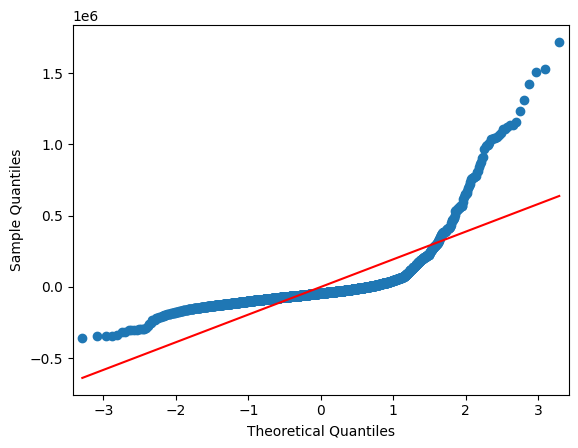

In [68]:
# Regression Model number 2
import matplotlib as plt

for col in df.select_dtypes(include='bool').columns:
    df[col] = df[col].astype(int)

x = df[['customer_age', 'customer_income', 'customer_type_online', 'customer_type_phone', 'household_size', 'mode_color_white', 'mode_color_red', 'mode_color_purple']]
y = df['net_customer_value']

x = sm.add_constant(x)

model = sm.OLS(y, x).fit()

print(model.summary())

predictions = model.predict(x)
residuals = y - predictions
sm.qqplot(residuals, line='s')
plt.show()

Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/7.8 MB ? eta -:--:--
   -------------------------------------- - 7.6/7.8 MB 42.7 MB/s eta 0:00:01
   ---------------------------------------- 7.8/7.8 MB 34.6 MB/s eta 0:00:00
   ---------------------------------------- 0.0/2.2 MB ? eta -:--:--
   ---------------------------------------- 2.2/2.2 MB 62.5 MB/s eta 0:00:00
   ---------------------------------------- 0.0/2.6 MB ? eta -:--:--
   ---------------------------------------- 2.6/2.6 MB 50.1 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: C:\Users\tucke\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip
